<a href="https://colab.research.google.com/github/vedapragna/EVA_S6/blob/master/EVA4_S6_Assignment_L1%26L2_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                       transforms.RandomRotation((-3.0, 3.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                    
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False)
            ,nn.BatchNorm2d(16)
            ,nn.ReLU()
            ,nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False)
            ,nn.BatchNorm2d(16)
            ,nn.ReLU()
            ,nn.Dropout(dropout_value)   
        ) # output_size = 24


        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False)  
        ) # output_size = 12

       # CONVOLUTION BLOCK 2

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=10, kernel_size=(3, 3), padding=0, bias=False)
            ,nn.BatchNorm2d(10)
            ,nn.ReLU()
            ,nn.Dropout(dropout_value)
            
        )#10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False)
            ,nn.BatchNorm2d(16)
            ,nn.ReLU()
            ,nn.Dropout(dropout_value)
        )#8

        # OUTPUT BLOCK
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False)
             ,nn.BatchNorm2d(16)
             ,nn.ReLU()
             ,nn.Dropout(dropout_value)
        )#6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False)
             ,nn.BatchNorm2d(16)
             ,nn.ReLU()
             ,nn.Dropout(dropout_value)
        )#4 
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4)
        ) # output_size = 1 
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
             ,nn.BatchNorm2d(10)
             ,nn.ReLU()
        )#4  

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)       
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [6]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
       BatchNorm2d-2           [-1, 16, 26, 26]              32
              ReLU-3           [-1, 16, 26, 26]               0
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
       BatchNorm2d-6           [-1, 16, 24, 24]              32
              ReLU-7           [-1, 16, 24, 24]               0
           Dropout-8           [-1, 16, 24, 24]               0
         MaxPool2d-9           [-1, 16, 12, 12]               0
           Conv2d-10            [-1, 8, 12, 12]             128
           Conv2d-11           [-1, 10, 10, 10]             720
      BatchNorm2d-12           [-1, 10, 10, 10]              20
             ReLU-13           [-1, 10, 10, 10]               0
          Dropout-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm



def train(model, device, train_loader, optimizer, epoch, reg_flag):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)
    #print(target)
    
    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    if (reg_flag == "L1") or (reg_flag == "L1 & L2") :
        # print("Reg: " + reg_flag) 
        reg_loss = 0
        for param in model.parameters():
                #reg_loss += l1_crit(param)
                reg_loss += torch.sum(torch.abs(param))
        factor = 0.0005
        loss += factor * reg_loss

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader, reg_flg):
    model.eval()
    test_loss = 0
    correct = 0
    flg = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            
            # Saving misclassified Images and their actual and pedicted labels
            tgt = target.view_as(pred)
            comp_df= pred.eq(tgt)
            mis_c = ~comp_df
            if flg == 0:
                misc_im = data[mis_c]
                misc_tr = tgt[mis_c]
                misc_pred = pred[mis_c]
                flg =1
            else:  
                misc_im = torch.cat((data[mis_c],misc_im))
                misc_tr = torch.cat((tgt[mis_c],misc_tr))
                misc_pred = torch.cat((pred[mis_c],misc_pred))              

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))
    return misc_im,misc_tr,misc_pred
        



####Train 4 models with versions are follows:

1. Without any Regularisation

2. With L1 Regularisation with alpha = 0.0005

3. With L2 Regularisation with alpha = 0.0005

4. With L1 & L2 Regularisation with alpha = 0.0005



In [8]:
reg_types = ["WO_reg","L1","L2","L1 & L2"]
EPOCHS = 40
import pandas as pd
import numpy as np

for reg_flag in reg_types:
    train_losses = []
    test_losses = []
    train_acc = []
    test_acc = []
    
    print("Training" + "WO_reg\n")
    model =  Net().to(device)
    if reg_flag == "L2" :
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay = 0.0005 )
    elif reg_flag == "L1 & L2" :
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay = 0.0005 )
    else:
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

    for epoch in range(EPOCHS):
        print("EPOCH:", epoch)
        train(model, device, train_loader, optimizer, epoch,reg_flag)
        if reg_flag == "L1":
            misc_im,misc_tr,misc_pred = test(model, device, test_loader,reg_flag)
        elif reg_flag == "L2":
            misc_im_l2,misc_tr_l2,misc_pred_l2 = test(model, device, test_loader,reg_flag)
        else:
            test(model, device, test_loader,reg_flag)

    df_list = pd.DataFrame(np.column_stack([test_losses, test_acc]), 
                                columns=['test_losses', 'test_acc'])
    df_list['epoch'] = range(0,EPOCHS)
    

    if reg_flag == "WO_reg":
        df_list = df_list.rename(columns = {"test_losses": "WO_reg_loss", "test_acc":"WO_reg_Accuracy"})
        df = df_list.copy(deep = True)
    else:
        df_list = df_list.rename(columns = {"test_losses": reg_flag+"_loss", "test_acc":reg_flag+"_Accuracy"})
        df = pd.merge(left=df.copy(deep = True), right=df_list.copy(deep = True), how='inner')


  0%|          | 0/469 [00:00<?, ?it/s]

TrainingWO_reg

EPOCH: 0


Loss=0.09412255883216858 Batch_id=468 Accuracy=93.02: 100%|██████████| 469/469 [00:14<00:00, 32.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1044, Accuracy: 9793/10000 (97.93%)

EPOCH: 1


Loss=0.07570502907037735 Batch_id=468 Accuracy=97.63: 100%|██████████| 469/469 [00:14<00:00, 32.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0594, Accuracy: 9871/10000 (98.71%)

EPOCH: 2


Loss=0.07341469079256058 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:14<00:00, 31.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0478, Accuracy: 9880/10000 (98.80%)

EPOCH: 3


Loss=0.051930416375398636 Batch_id=468 Accuracy=98.28: 100%|██████████| 469/469 [00:14<00:00, 32.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Accuracy: 9886/10000 (98.86%)

EPOCH: 4


Loss=0.13205693662166595 Batch_id=468 Accuracy=98.42: 100%|██████████| 469/469 [00:14<00:00, 31.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9914/10000 (99.14%)

EPOCH: 5


Loss=0.027744228020310402 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:14<00:00, 32.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0397, Accuracy: 9886/10000 (98.86%)

EPOCH: 6


Loss=0.07918327301740646 Batch_id=468 Accuracy=98.60: 100%|██████████| 469/469 [00:14<00:00, 33.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9908/10000 (99.08%)

EPOCH: 7


Loss=0.04184190556406975 Batch_id=468 Accuracy=98.69: 100%|██████████| 469/469 [00:13<00:00, 33.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9916/10000 (99.16%)

EPOCH: 8


Loss=0.0951085165143013 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:14<00:00, 37.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9908/10000 (99.08%)

EPOCH: 9


Loss=0.04887930676341057 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:14<00:00, 31.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9910/10000 (99.10%)

EPOCH: 10


Loss=0.018995100632309914 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:13<00:00, 34.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9897/10000 (98.97%)

EPOCH: 11


Loss=0.07329010218381882 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:13<00:00, 33.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9901/10000 (99.01%)

EPOCH: 12


Loss=0.019110584631562233 Batch_id=468 Accuracy=98.83: 100%|██████████| 469/469 [00:13<00:00, 34.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0294, Accuracy: 9915/10000 (99.15%)

EPOCH: 13


Loss=0.03149600327014923 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:14<00:00, 33.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9931/10000 (99.31%)

EPOCH: 14


Loss=0.015994736924767494 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:13<00:00, 33.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9924/10000 (99.24%)

EPOCH: 15


Loss=0.06023462116718292 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:13<00:00, 33.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9926/10000 (99.26%)

EPOCH: 16


Loss=0.08296626061201096 Batch_id=468 Accuracy=98.93: 100%|██████████| 469/469 [00:13<00:00, 34.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9915/10000 (99.15%)

EPOCH: 17


Loss=0.03670641407370567 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:14<00:00, 33.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9926/10000 (99.26%)

EPOCH: 18


Loss=0.09004702419042587 Batch_id=468 Accuracy=98.94: 100%|██████████| 469/469 [00:13<00:00, 34.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9924/10000 (99.24%)

EPOCH: 19


Loss=0.05805554613471031 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:13<00:00, 33.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0290, Accuracy: 9912/10000 (99.12%)

EPOCH: 20


Loss=0.02844882570207119 Batch_id=468 Accuracy=99.04: 100%|██████████| 469/469 [00:13<00:00, 34.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9911/10000 (99.11%)

EPOCH: 21


Loss=0.016402622684836388 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:13<00:00, 37.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9937/10000 (99.37%)

EPOCH: 22


Loss=0.01126136351376772 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 35.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9916/10000 (99.16%)

EPOCH: 23


Loss=0.005627145525068045 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 34.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9921/10000 (99.21%)

EPOCH: 24


Loss=0.015016620047390461 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:13<00:00, 35.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9930/10000 (99.30%)

EPOCH: 25


Loss=0.01780918799340725 Batch_id=468 Accuracy=99.12: 100%|██████████| 469/469 [00:13<00:00, 41.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9934/10000 (99.34%)

EPOCH: 26


Loss=0.006129130721092224 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:12<00:00, 36.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9931/10000 (99.31%)

EPOCH: 27


Loss=0.021204104647040367 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:12<00:00, 36.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9931/10000 (99.31%)

EPOCH: 28


Loss=0.0189023669809103 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:13<00:00, 35.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9927/10000 (99.27%)

EPOCH: 29


Loss=0.004845867399126291 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:14<00:00, 32.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9930/10000 (99.30%)

EPOCH: 30


Loss=0.027757996693253517 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:13<00:00, 35.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9927/10000 (99.27%)

EPOCH: 31


Loss=0.003728508949279785 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:13<00:00, 35.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9922/10000 (99.22%)

EPOCH: 32


Loss=0.012864381074905396 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:12<00:00, 36.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0278, Accuracy: 9921/10000 (99.21%)

EPOCH: 33


Loss=0.043639373034238815 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 43.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9935/10000 (99.35%)

EPOCH: 34


Loss=0.005189324263483286 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 43.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0292, Accuracy: 9922/10000 (99.22%)

EPOCH: 35


Loss=0.011663571000099182 Batch_id=468 Accuracy=99.18: 100%|██████████| 469/469 [00:13<00:00, 35.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9930/10000 (99.30%)

EPOCH: 36


Loss=0.07916716486215591 Batch_id=468 Accuracy=99.21: 100%|██████████| 469/469 [00:12<00:00, 36.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0220, Accuracy: 9941/10000 (99.41%)

EPOCH: 37


Loss=0.007737686391919851 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:13<00:00, 35.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9935/10000 (99.35%)

EPOCH: 38


Loss=0.014247938990592957 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:12<00:00, 36.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9934/10000 (99.34%)

EPOCH: 39


Loss=0.00551295792683959 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:13<00:00, 36.00it/s]



Test set: Average loss: 0.0228, Accuracy: 9938/10000 (99.38%)



  0%|          | 0/469 [00:00<?, ?it/s]

TrainingWO_reg

EPOCH: 0


Loss=0.3812921345233917 Batch_id=468 Accuracy=92.47: 100%|██████████| 469/469 [00:14<00:00, 33.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1173, Accuracy: 9761/10000 (97.61%)

EPOCH: 1


Loss=0.27390602231025696 Batch_id=468 Accuracy=97.56: 100%|██████████| 469/469 [00:14<00:00, 31.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0852, Accuracy: 9808/10000 (98.08%)

EPOCH: 2


Loss=0.23974010348320007 Batch_id=468 Accuracy=97.79: 100%|██████████| 469/469 [00:13<00:00, 35.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0518, Accuracy: 9863/10000 (98.63%)

EPOCH: 3


Loss=0.2608277499675751 Batch_id=468 Accuracy=97.86: 100%|██████████| 469/469 [00:13<00:00, 34.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0661, Accuracy: 9819/10000 (98.19%)

EPOCH: 4


Loss=0.21460884809494019 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:13<00:00, 33.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0441, Accuracy: 9891/10000 (98.91%)

EPOCH: 5


Loss=0.19598932564258575 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:14<00:00, 32.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0648, Accuracy: 9824/10000 (98.24%)

EPOCH: 6


Loss=0.1969621181488037 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:13<00:00, 34.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0443, Accuracy: 9865/10000 (98.65%)

EPOCH: 7


Loss=0.2373630702495575 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:14<00:00, 33.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0421, Accuracy: 9887/10000 (98.87%)

EPOCH: 8


Loss=0.1992115080356598 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:14<00:00, 33.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0469, Accuracy: 9860/10000 (98.60%)

EPOCH: 9


Loss=0.21371793746948242 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:14<00:00, 32.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0485, Accuracy: 9862/10000 (98.62%)

EPOCH: 10


Loss=0.17592491209506989 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:14<00:00, 33.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0615, Accuracy: 9830/10000 (98.30%)

EPOCH: 11


Loss=0.22361773252487183 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:13<00:00, 40.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0577, Accuracy: 9828/10000 (98.28%)

EPOCH: 12


Loss=0.27337348461151123 Batch_id=468 Accuracy=98.01: 100%|██████████| 469/469 [00:13<00:00, 33.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0408, Accuracy: 9875/10000 (98.75%)

EPOCH: 13


Loss=0.18712544441223145 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:14<00:00, 33.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9865/10000 (98.65%)

EPOCH: 14


Loss=0.21672531962394714 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:13<00:00, 38.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0473, Accuracy: 9857/10000 (98.57%)

EPOCH: 15


Loss=0.2617388069629669 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:13<00:00, 33.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Accuracy: 9866/10000 (98.66%)

EPOCH: 16


Loss=0.15475676953792572 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:13<00:00, 34.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Accuracy: 9892/10000 (98.92%)

EPOCH: 17


Loss=0.19608458876609802 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:14<00:00, 32.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9854/10000 (98.54%)

EPOCH: 18


Loss=0.20523163676261902 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:13<00:00, 33.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0498, Accuracy: 9861/10000 (98.61%)

EPOCH: 19


Loss=0.2394101917743683 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:14<00:00, 41.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0435, Accuracy: 9878/10000 (98.78%)

EPOCH: 20


Loss=0.2062613070011139 Batch_id=468 Accuracy=98.20: 100%|██████████| 469/469 [00:13<00:00, 34.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Accuracy: 9886/10000 (98.86%)

EPOCH: 21


Loss=0.22409109771251678 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:14<00:00, 33.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0497, Accuracy: 9845/10000 (98.45%)

EPOCH: 22


Loss=0.20624323189258575 Batch_id=468 Accuracy=98.21: 100%|██████████| 469/469 [00:13<00:00, 34.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0489, Accuracy: 9846/10000 (98.46%)

EPOCH: 23


Loss=0.1818963587284088 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:13<00:00, 34.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Accuracy: 9875/10000 (98.75%)

EPOCH: 24


Loss=0.25989288091659546 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:13<00:00, 33.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0383, Accuracy: 9894/10000 (98.94%)

EPOCH: 25


Loss=0.22034673392772675 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:13<00:00, 34.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0608, Accuracy: 9803/10000 (98.03%)

EPOCH: 26


Loss=0.18881945312023163 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:13<00:00, 34.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0497, Accuracy: 9840/10000 (98.40%)

EPOCH: 27


Loss=0.17017187178134918 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:13<00:00, 42.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0439, Accuracy: 9865/10000 (98.65%)

EPOCH: 28


Loss=0.21416741609573364 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:14<00:00, 31.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Accuracy: 9894/10000 (98.94%)

EPOCH: 29


Loss=0.24022087454795837 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:14<00:00, 31.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Accuracy: 9883/10000 (98.83%)

EPOCH: 30


Loss=0.26538151502609253 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:15<00:00, 31.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0355, Accuracy: 9900/10000 (99.00%)

EPOCH: 31


Loss=0.2077242136001587 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:14<00:00, 31.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9880/10000 (98.80%)

EPOCH: 32


Loss=0.18324856460094452 Batch_id=468 Accuracy=98.18: 100%|██████████| 469/469 [00:15<00:00, 29.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Accuracy: 9870/10000 (98.70%)

EPOCH: 33


Loss=0.22177721560001373 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:14<00:00, 32.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0402, Accuracy: 9872/10000 (98.72%)

EPOCH: 34


Loss=0.23294545710086823 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:14<00:00, 32.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Accuracy: 9870/10000 (98.70%)

EPOCH: 35


Loss=0.23263268172740936 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:14<00:00, 39.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9921/10000 (99.21%)

EPOCH: 36


Loss=0.2198493480682373 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:15<00:00, 30.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0561, Accuracy: 9834/10000 (98.34%)

EPOCH: 37


Loss=0.23512622714042664 Batch_id=468 Accuracy=98.15: 100%|██████████| 469/469 [00:14<00:00, 36.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0379, Accuracy: 9898/10000 (98.98%)

EPOCH: 38


Loss=0.19251731038093567 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:14<00:00, 33.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 9885/10000 (98.85%)

EPOCH: 39


Loss=0.17048774659633636 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:14<00:00, 32.92it/s]



Test set: Average loss: 0.0431, Accuracy: 9879/10000 (98.79%)



  0%|          | 0/469 [00:00<?, ?it/s]

TrainingWO_reg

EPOCH: 0


Loss=0.1531144082546234 Batch_id=468 Accuracy=93.04: 100%|██████████| 469/469 [00:12<00:00, 36.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1022, Accuracy: 9771/10000 (97.71%)

EPOCH: 1


Loss=0.1278785914182663 Batch_id=468 Accuracy=97.65: 100%|██████████| 469/469 [00:12<00:00, 36.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0629, Accuracy: 9855/10000 (98.55%)

EPOCH: 2


Loss=0.11745721101760864 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:13<00:00, 35.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0488, Accuracy: 9876/10000 (98.76%)

EPOCH: 3


Loss=0.04114190861582756 Batch_id=468 Accuracy=98.32: 100%|██████████| 469/469 [00:13<00:00, 35.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0380, Accuracy: 9893/10000 (98.93%)

EPOCH: 4


Loss=0.05218350514769554 Batch_id=468 Accuracy=98.40: 100%|██████████| 469/469 [00:12<00:00, 45.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9904/10000 (99.04%)

EPOCH: 5


Loss=0.039146024733781815 Batch_id=468 Accuracy=98.51: 100%|██████████| 469/469 [00:12<00:00, 37.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9919/10000 (99.19%)

EPOCH: 6


Loss=0.06812373548746109 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:12<00:00, 36.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0336, Accuracy: 9900/10000 (99.00%)

EPOCH: 7


Loss=0.0422697514295578 Batch_id=468 Accuracy=98.61: 100%|██████████| 469/469 [00:13<00:00, 35.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9910/10000 (99.10%)

EPOCH: 8


Loss=0.043466243892908096 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:13<00:00, 35.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0323, Accuracy: 9913/10000 (99.13%)

EPOCH: 9


Loss=0.03135084733366966 Batch_id=468 Accuracy=98.75: 100%|██████████| 469/469 [00:12<00:00, 36.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9922/10000 (99.22%)

EPOCH: 10


Loss=0.06700026243925095 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:13<00:00, 35.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9904/10000 (99.04%)

EPOCH: 11


Loss=0.04425942525267601 Batch_id=468 Accuracy=98.81: 100%|██████████| 469/469 [00:12<00:00, 33.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0287, Accuracy: 9917/10000 (99.17%)

EPOCH: 12


Loss=0.041788533329963684 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:13<00:00, 35.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9920/10000 (99.20%)

EPOCH: 13


Loss=0.11267838627099991 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:12<00:00, 36.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9926/10000 (99.26%)

EPOCH: 14


Loss=0.036144595593214035 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:12<00:00, 36.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9925/10000 (99.25%)

EPOCH: 15


Loss=0.012752125971019268 Batch_id=468 Accuracy=98.89: 100%|██████████| 469/469 [00:12<00:00, 36.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0244, Accuracy: 9924/10000 (99.24%)

EPOCH: 16


Loss=0.04552530124783516 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:13<00:00, 35.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9925/10000 (99.25%)

EPOCH: 17


Loss=0.03669051080942154 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:12<00:00, 37.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9917/10000 (99.17%)

EPOCH: 18


Loss=0.03740066662430763 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:13<00:00, 36.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9935/10000 (99.35%)

EPOCH: 19


Loss=0.023098260164260864 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:12<00:00, 36.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9927/10000 (99.27%)

EPOCH: 20


Loss=0.05886005237698555 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:13<00:00, 35.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9928/10000 (99.28%)

EPOCH: 21


Loss=0.09421279281377792 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:12<00:00, 36.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9928/10000 (99.28%)

EPOCH: 22


Loss=0.032452575862407684 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:12<00:00, 36.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9925/10000 (99.25%)

EPOCH: 23


Loss=0.020865952596068382 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:12<00:00, 36.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9920/10000 (99.20%)

EPOCH: 24


Loss=0.03385719284415245 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:13<00:00, 35.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9919/10000 (99.19%)

EPOCH: 25


Loss=0.04639722406864166 Batch_id=468 Accuracy=99.00: 100%|██████████| 469/469 [00:12<00:00, 36.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0233, Accuracy: 9935/10000 (99.35%)

EPOCH: 26


Loss=0.05626470968127251 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:12<00:00, 36.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9921/10000 (99.21%)

EPOCH: 27


Loss=0.02899225987493992 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:12<00:00, 37.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9925/10000 (99.25%)

EPOCH: 28


Loss=0.11009326577186584 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:13<00:00, 35.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9937/10000 (99.37%)

EPOCH: 29


Loss=0.04020315036177635 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:13<00:00, 35.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9934/10000 (99.34%)

EPOCH: 30


Loss=0.030470654368400574 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:13<00:00, 35.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9921/10000 (99.21%)

EPOCH: 31


Loss=0.017662489786744118 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:13<00:00, 36.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0221, Accuracy: 9937/10000 (99.37%)

EPOCH: 32


Loss=0.049614910036325455 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:13<00:00, 35.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9932/10000 (99.32%)

EPOCH: 33


Loss=0.05561734363436699 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:13<00:00, 35.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0258, Accuracy: 9923/10000 (99.23%)

EPOCH: 34


Loss=0.08731081336736679 Batch_id=468 Accuracy=99.05: 100%|██████████| 469/469 [00:13<00:00, 35.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9930/10000 (99.30%)

EPOCH: 35


Loss=0.019417783245444298 Batch_id=468 Accuracy=99.06: 100%|██████████| 469/469 [00:13<00:00, 35.46it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9942/10000 (99.42%)

EPOCH: 36


Loss=0.07816854864358902 Batch_id=468 Accuracy=99.13: 100%|██████████| 469/469 [00:13<00:00, 35.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9936/10000 (99.36%)

EPOCH: 37


Loss=0.009446382522583008 Batch_id=468 Accuracy=99.09: 100%|██████████| 469/469 [00:12<00:00, 36.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9936/10000 (99.36%)

EPOCH: 38


Loss=0.022173836827278137 Batch_id=468 Accuracy=99.08: 100%|██████████| 469/469 [00:12<00:00, 37.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9922/10000 (99.22%)

EPOCH: 39


Loss=0.014597192406654358 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:12<00:00, 36.28it/s]



Test set: Average loss: 0.0230, Accuracy: 9935/10000 (99.35%)



  0%|          | 0/469 [00:00<?, ?it/s]

TrainingWO_reg

EPOCH: 0


Loss=0.420748770236969 Batch_id=468 Accuracy=92.42: 100%|██████████| 469/469 [00:14<00:00, 32.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1459, Accuracy: 9685/10000 (96.85%)

EPOCH: 1


Loss=0.30747637152671814 Batch_id=468 Accuracy=97.55: 100%|██████████| 469/469 [00:14<00:00, 33.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0737, Accuracy: 9827/10000 (98.27%)

EPOCH: 2


Loss=0.2555829584598541 Batch_id=468 Accuracy=97.72: 100%|██████████| 469/469 [00:13<00:00, 33.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0603, Accuracy: 9849/10000 (98.49%)

EPOCH: 3


Loss=0.21615010499954224 Batch_id=468 Accuracy=97.91: 100%|██████████| 469/469 [00:13<00:00, 34.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0509, Accuracy: 9879/10000 (98.79%)

EPOCH: 4


Loss=0.3033681809902191 Batch_id=468 Accuracy=97.87: 100%|██████████| 469/469 [00:14<00:00, 32.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0680, Accuracy: 9824/10000 (98.24%)

EPOCH: 5


Loss=0.2293429672718048 Batch_id=468 Accuracy=97.88: 100%|██████████| 469/469 [00:13<00:00, 33.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0564, Accuracy: 9858/10000 (98.58%)

EPOCH: 6


Loss=0.276432067155838 Batch_id=468 Accuracy=97.95: 100%|██████████| 469/469 [00:14<00:00, 32.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9884/10000 (98.84%)

EPOCH: 7


Loss=0.2402094602584839 Batch_id=468 Accuracy=97.89: 100%|██████████| 469/469 [00:13<00:00, 33.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0586, Accuracy: 9827/10000 (98.27%)

EPOCH: 8


Loss=0.2993401288986206 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:14<00:00, 32.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0581, Accuracy: 9838/10000 (98.38%)

EPOCH: 9


Loss=0.2702822685241699 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:13<00:00, 33.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0513, Accuracy: 9872/10000 (98.72%)

EPOCH: 10


Loss=0.28320419788360596 Batch_id=468 Accuracy=97.97: 100%|██████████| 469/469 [00:14<00:00, 32.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0432, Accuracy: 9888/10000 (98.88%)

EPOCH: 11


Loss=0.2206653356552124 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:13<00:00, 40.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0428, Accuracy: 9885/10000 (98.85%)

EPOCH: 12


Loss=0.16263000667095184 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:14<00:00, 37.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0605, Accuracy: 9832/10000 (98.32%)

EPOCH: 13


Loss=0.18180739879608154 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:13<00:00, 34.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0525, Accuracy: 9856/10000 (98.56%)

EPOCH: 14


Loss=0.2289913296699524 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:13<00:00, 33.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0560, Accuracy: 9844/10000 (98.44%)

EPOCH: 15


Loss=0.2342224419116974 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:13<00:00, 34.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0458, Accuracy: 9870/10000 (98.70%)

EPOCH: 16


Loss=0.20479831099510193 Batch_id=468 Accuracy=98.07: 100%|██████████| 469/469 [00:14<00:00, 32.88it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0459, Accuracy: 9881/10000 (98.81%)

EPOCH: 17


Loss=0.24815568327903748 Batch_id=468 Accuracy=98.12: 100%|██████████| 469/469 [00:13<00:00, 40.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0437, Accuracy: 9877/10000 (98.77%)

EPOCH: 18


Loss=0.20633020997047424 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:13<00:00, 33.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0504, Accuracy: 9859/10000 (98.59%)

EPOCH: 19


Loss=0.1576826125383377 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:13<00:00, 33.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0506, Accuracy: 9857/10000 (98.57%)

EPOCH: 20


Loss=0.16885748505592346 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:13<00:00, 34.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0494, Accuracy: 9879/10000 (98.79%)

EPOCH: 21


Loss=0.13788214325904846 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:13<00:00, 34.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0510, Accuracy: 9875/10000 (98.75%)

EPOCH: 22


Loss=0.2790837585926056 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:13<00:00, 33.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0493, Accuracy: 9868/10000 (98.68%)

EPOCH: 23


Loss=0.16666918992996216 Batch_id=468 Accuracy=98.00: 100%|██████████| 469/469 [00:14<00:00, 32.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0579, Accuracy: 9838/10000 (98.38%)

EPOCH: 24


Loss=0.18240877985954285 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:13<00:00, 34.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0647, Accuracy: 9817/10000 (98.17%)

EPOCH: 25


Loss=0.1696873903274536 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:13<00:00, 34.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0501, Accuracy: 9852/10000 (98.52%)

EPOCH: 26


Loss=0.14095506072044373 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:13<00:00, 34.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0552, Accuracy: 9846/10000 (98.46%)

EPOCH: 27


Loss=0.1410972625017166 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:14<00:00, 32.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0447, Accuracy: 9885/10000 (98.85%)

EPOCH: 28


Loss=0.14433516561985016 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:14<00:00, 33.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0529, Accuracy: 9856/10000 (98.56%)

EPOCH: 29


Loss=0.19348391890525818 Batch_id=468 Accuracy=98.02: 100%|██████████| 469/469 [00:14<00:00, 33.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0555, Accuracy: 9866/10000 (98.66%)

EPOCH: 30


Loss=0.1719190776348114 Batch_id=468 Accuracy=98.10: 100%|██████████| 469/469 [00:14<00:00, 33.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0398, Accuracy: 9889/10000 (98.89%)

EPOCH: 31


Loss=0.17443566024303436 Batch_id=468 Accuracy=98.06: 100%|██████████| 469/469 [00:15<00:00, 30.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0512, Accuracy: 9862/10000 (98.62%)

EPOCH: 32


Loss=0.19715657830238342 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:13<00:00, 34.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0471, Accuracy: 9876/10000 (98.76%)

EPOCH: 33


Loss=0.18587246537208557 Batch_id=468 Accuracy=98.11: 100%|██████████| 469/469 [00:14<00:00, 32.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0419, Accuracy: 9883/10000 (98.83%)

EPOCH: 34


Loss=0.1923234462738037 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:13<00:00, 33.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0560, Accuracy: 9852/10000 (98.52%)

EPOCH: 35


Loss=0.16765771806240082 Batch_id=468 Accuracy=97.98: 100%|██████████| 469/469 [00:14<00:00, 32.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Accuracy: 9894/10000 (98.94%)

EPOCH: 36


Loss=0.18625806272029877 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:13<00:00, 41.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0409, Accuracy: 9885/10000 (98.85%)

EPOCH: 37


Loss=0.1294628083705902 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:13<00:00, 34.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0772, Accuracy: 9763/10000 (97.63%)

EPOCH: 38


Loss=0.16572049260139465 Batch_id=468 Accuracy=98.08: 100%|██████████| 469/469 [00:13<00:00, 34.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0381, Accuracy: 9892/10000 (98.92%)

EPOCH: 39


Loss=0.14043335616588593 Batch_id=468 Accuracy=98.04: 100%|██████████| 469/469 [00:14<00:00, 32.46it/s]



Test set: Average loss: 0.0458, Accuracy: 9872/10000 (98.72%)



###Best Accuracies of 4 models trained are follows:

Without any Regularisation : Train Accuracy = 99.25% , Test Accuracy = 99.38%

With L1 Regularisation with alpha = 0.0005 : Train Accuracy = 98.03% , Test Accuracy = 98.79%

With L2 Regularisation with alpha = 0.0005 : Train Accuracy = 99.14% , Test Accuracy = 99.35%

With L1 & L2 Regularisation with alpha = 0.0005 : Train Accuracy = 98.04% , Test Accuracy = 98.72%

## Plot the validation Accuracy and Validation Loss for four models trained

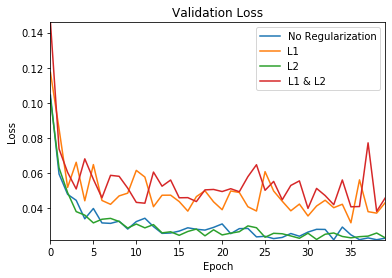

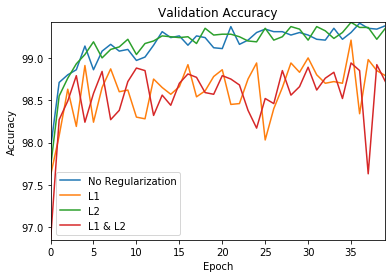

In [18]:

%matplotlib inline
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.plot(df['WO_reg_loss'],label='No Regularization')
ax.plot(df['L1_loss'],label='L1')
ax.plot(df['L2_loss'], label='L2')
ax.plot(df['L1 & L2_loss'], label='L1 & L2')
plt.autoscale(enable = True, axis = 'both',tight = 'true')
plt.title("Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
leg = ax.legend();

from google.colab import files
plt.savefig("validation_loss.png")
files.download("validation_loss.png")

fig, ax = plt.subplots()
ax.plot(df['WO_reg_Accuracy'],label='No Regularization')
ax.plot(df['L1_Accuracy'],label='L1')
ax.plot(df['L2_Accuracy'], label='L2')
ax.plot(df['L1 & L2_Accuracy'], label='L1 & L2')
plt.autoscale(enable = True, axis = 'both',tight = 'true')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
leg = ax.legend();

from google.colab import files
plt.savefig("Validation_Accuracy.png")
files.download("Validation_Accuracy.png")


### Plot 25 Misclassified Images for L1 and L2 Regularised models separately


torch.Size([65, 28, 28])
torch.Size([121, 28, 28])
torch.Size([65])
torch.Size([121])
torch.Size([65])
torch.Size([121])


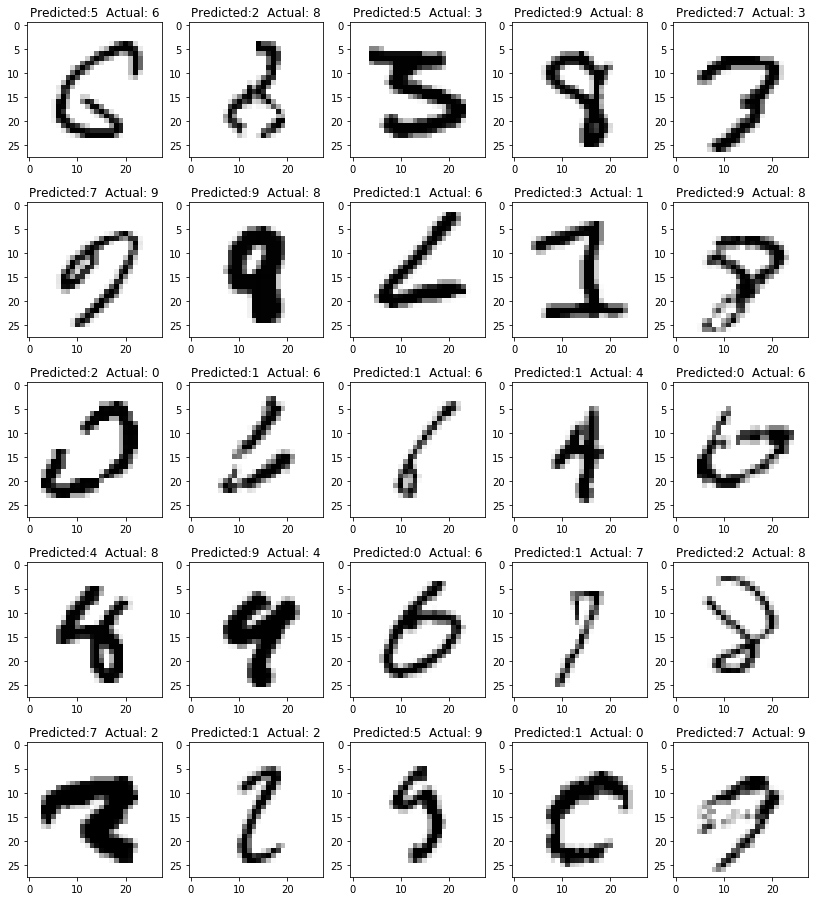

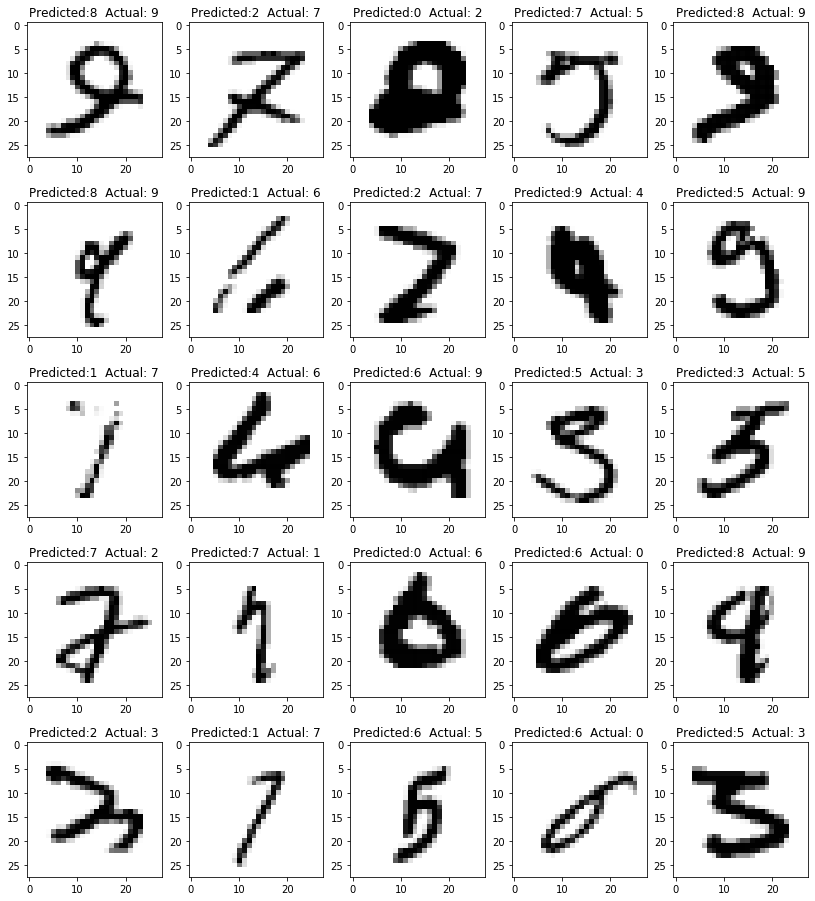

In [10]:
print(misc_im_l2.shape)
print(misc_im.shape)
print(misc_tr_l2.shape)
print(misc_tr.shape)
print(misc_pred_l2.shape)
print(misc_pred.shape)
%matplotlib inline
import matplotlib.pyplot as plt 

fig=plt.figure(figsize=(14, 16))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = misc_im[i-1].to(torch.device("cpu"))
    p = misc_pred[i-1].to(torch.device("cpu"))
    t = misc_tr[i-1].to(torch.device("cpu"))
    #img = img.permute(1, 2, 0)
    fig.add_subplot(rows, columns, i)
    #plt.imshow(img[:, :, 0].numpy().squeeze(),cmap='gray_r')
    plt.imshow(img.numpy().squeeze(),cmap='gray_r')
    plt.title("Predicted:"+str(p)[7:8]+"  Actual: "+str(t)[7:8])
#plt.show()
from google.colab import files
plt.savefig("L1_Misclassified_Images.png")
files.download("L1_Misclassified_Images.png")

fig=plt.figure(figsize=(14, 16))
columns = 5
rows = 5
for i in range(1, columns*rows +1):
    img = misc_im_l2[i-1].to(torch.device("cpu"))
    p = misc_pred_l2[i-1].to(torch.device("cpu"))
    t = misc_tr_l2[i-1].to(torch.device("cpu"))
    #img = img.permute(1, 2, 0)
    fig.add_subplot(rows, columns, i)
    #plt.imshow(img[:, :, 0].numpy().squeeze(),cmap='gray_r')
    plt.imshow(img.numpy().squeeze(),cmap='gray_r')
    plt.title("Predicted:"+str(p)[7:8]+"  Actual: "+str(t)[7:8])
#plt.show()

from google.colab import files
plt.savefig("L2_Misclassified_Images.png")
files.download("L2_Misclassified_Images.png")